In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!git branch -M main

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
print(os.path.exists(train_dir))
print(os.path.exists(val_dir))
print(os.path.exists(test_dir))


False
False
False


In [ ]:
project_path = '/content/drive/MyDrive/Indian_Traffic_Signs_Project'

train_dir = f"{project_path}/dataset/split_data/train"
val_dir = f"{project_path}/dataset/split_data/val"
test_dir = f"{project_path}/dataset/split_data/test"

model_path = f"{project_path}/checkpoints/baseline_cnn_quick.h5"

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

datagen = ImageDataGenerator(rescale=1./255)
train_data = datagen.flow_from_directory(train_dir, target_size=(128,128), batch_size=32, class_mode='categorical')
val_data = datagen.flow_from_directory(val_dir, target_size=(128,128), batch_size=32, class_mode='categorical')
test_data = datagen.flow_from_directory(test_dir, target_size=(128,128), batch_size=32, class_mode='categorical', shuffle=False)

model = load_model(model_path)
print("✅ Model loaded successfully from shared Drive.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Indian_Traffic_Signs_Project/dataset/split_data/train'

In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print(f"🧠 Baseline CNN Test Accuracy: {test_acc*100:.2f}%")


 2/67 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.0000e+00 - loss: 4.0198

KeyboardInterrupt: 

In [ ]:
# ==========================================================
# 🔹 Evaluate the existing Custom CNN model on test data
# ==========================================================
test_loss, test_acc = model.evaluate(test_data, verbose=1)
print(f"\n🧠 Baseline CNN Test Accuracy: {test_acc*100:.2f}%")
print(f"🧠 Baseline CNN Test Loss: {test_loss:.4f}")

# ==========================================================
# 🔹 (Optional) Generate Predictions for Detailed Metrics
# ==========================================================
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test data
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(test_data.class_indices.keys())))

# Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap='Blues', xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys(), fmt='d')
plt.title("🧩 Confusion Matrix — Custom CNN")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

 4/67 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - accuracy: 0.0046 - loss: 3.9062  

KeyboardInterrupt: 

In [ ]:
# ==========================================================
# 🔹 1. Imports
# ==========================================================
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os

# ==========================================================
# 🔹 2. Define Project Paths
# ==========================================================
project_path = '/content/drive/MyDrive/Indian_Traffic_Signs_Project'
checkpoint_dir = f"{project_path}/checkpoints"
model_dir = f"{project_path}/models"

# Make sure folders exist
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

# ==========================================================
# 🔹 3. Load Dataset (Already Created)
# ==========================================================
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 32

train_dir = f"{project_path}/dataset/split_data/train"
val_dir = f"{project_path}/dataset/split_data/val"
test_dir = f"{project_path}/dataset/split_data/test"

datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_data   = datagen.flow_from_directory(val_dir,   target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_data  = datagen.flow_from_directory(test_dir,  target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

# ==========================================================
# 🔹 4. Build MobileNetV2 Model
# ==========================================================
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable = False  # freeze base layers for speed and stability

num_classes = train_data.num_classes

model_mobilenet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_mobilenet.summary()

# ==========================================================
# 🔹 5. Define Checkpoints (Auto-Save Best Model)
# ==========================================================
checkpoint_path = f"{checkpoint_dir}/mobilenetv2_best.h5"

callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
]

# ==========================================================
# 🔹 6. Train the Model (Quick 5 Epochs)
# ==========================================================
history_mnet = model_mobilenet.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    callbacks=callbacks,
    verbose=1
)

# ==========================================================
# 🔹 7. Evaluate on Test Data
# ==========================================================
test_loss, test_acc = model_mobilenet.evaluate(test_data)
print(f"\n🏁 MobileNetV2 Test Accuracy: {test_acc*100:.2f}%")
print(f"🏁 MobileNetV2 Test Loss: {test_loss:.4f}")

# ==========================================================
# 🔹 8. Save Final Model (Modern Keras Format)
# ==========================================================
final_model_path = f"{model_dir}/mobilenetv2_final.keras"
model_mobilenet.save(final_model_path)
print(f"\n💾 Final model saved at: {final_model_path}")

# ==========================================================
# 🔹 9. Optional: Verify Saved Files
# ==========================================================
print("\n📂 Saved Files in Drive:")
print(os.listdir(model_dir))
print(os.listdir(checkpoint_dir))

In [ ]:
# ==========================================================
# 🔹 Evaluate the existing Custom CNN model on test data
# ==========================================================
test_loss, test_acc = model.evaluate(test_data, verbose=1)
print(f"\n🧠 Baseline CNN Test Accuracy: {test_acc*100:.2f}%")
print(f"🧠 Baseline CNN Test Loss: {test_loss:.4f}")

# ==========================================================
# 🔹 (Optional) Generate Predictions for Detailed Metrics
# ==========================================================
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test data
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(test_data.class_indices.keys())))

# Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap='Blues', xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys(), fmt='d')
plt.title("🧩 Confusion Matrix — Custom CNN")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

project_path = '/content/drive/MyDrive/Indian_Traffic_Signs_Project'
model_path = f"{project_path}/models/mobilenetv2_final.keras"

model_mobilenet = load_model(model_path)
print("✅ MobileNetV2 model reloaded successfully!")

In [ ]:
from tensorflow.keras.models import load_model

project_path = '/content/drive/MyDrive/Indian_Traffic_Signs_Project'
model_path_mnet = f"{project_path}/models/mobilenetv2_final.keras"
model_mobilenet = load_model(model_path_mnet)

# Recreate dataset generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 32

train_dir = f"{project_path}/dataset/split_data/train"
val_dir = f"{project_path}/dataset/split_data/val"
test_dir = f"{project_path}/dataset/split_data/test"

datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_data   = datagen.flow_from_directory(val_dir,   target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_data  = datagen.flow_from_directory(test_dir,  target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

# Evaluate MobileNetV2 model
test_loss, test_acc = model_mobilenet.evaluate(test_data)
print(f"🏁 MobileNetV2 Test Accuracy: {test_acc*100:.2f}%")
print(f"🏁 MobileNetV2 Test Loss: {test_loss:.4f}")

In [ ]:
# Compare with Custom CNN
from tensorflow.keras.models import load_model
baseline_model = load_model(f"{project_path}/checkpoints/baseline_cnn_quick.h5")

baseline_loss, baseline_acc = baseline_model.evaluate(test_data, verbose=0)

import pandas as pd

comparison_data = {
    'Model': ['Custom CNN', 'MobileNetV2'],
    'Test Accuracy (%)': [round(baseline_acc*100,2), round(test_acc*100,2)],
    'Test Loss': [round(baseline_loss,4), round(test_loss,4)]
}
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)

In [ ]:
# ==========================================================
# 🔹 Visual Comparison: Accuracy & Loss Bar Chart
# ==========================================================
import os
import matplotlib.pyplot as plt
import pandas as pd

# Create DataFrame (reuse your results)
comparison_data = {
    'Model': ['Custom CNN', 'MobileNetV2'],
    'Test Accuracy (%)': [73.60, 78.41],
    'Test Loss': [0.7953, 0.8136]
}
comparison_df = pd.DataFrame(comparison_data)

# Save to CSV (for paper appendix)
project_path = '/content/drive/MyDrive/Indian_Traffic_Signs_Project'
comparison_csv_path = f"{project_path}/results/model_comparison_final.csv"

os.makedirs(os.path.dirname(comparison_csv_path), exist_ok=True)
comparison_df.to_csv(comparison_csv_path, index=False)
print(f"💾 Comparison results saved to: {comparison_csv_path}")

# Plot Accuracy Comparison
plt.figure(figsize=(8,5))
plt.bar(comparison_df['Model'], comparison_df['Test Accuracy (%)'], color=['skyblue', 'lightgreen'])
plt.title('Model Accuracy Comparison — Indian Traffic Sign Dataset', fontsize=13)
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
for i, val in enumerate(comparison_df['Test Accuracy (%)']):
    plt.text(i, val + 1, f"{val}%", ha='center', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot Loss Comparison
plt.figure(figsize=(8,5))
plt.bar(comparison_df['Model'], comparison_df['Test Loss'], color=['salmon', 'orange'])
plt.title('Model Loss Comparison — Indian Traffic Sign Dataset', fontsize=13)
plt.ylabel('Loss')
for i, val in enumerate(comparison_df['Test Loss']):
    plt.text(i, val + 0.02, f"{val:.3f}", ha='center', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
import sys
import tensorflow as tf
import platform

print("Python version:", sys.version)
print("TensorFlow version:", tf.__version__)
print("Is GPU available:", tf.config.list_physical_devices('GPU'))
print("Platform:", platform.platform())


In [ ]:
!nvidia-smi


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os


In [ ]:
!ls /content/drive


In [ ]:
import os
os.makedirs("/content/gdrive", exist_ok=True)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


In [ ]:
project_path = '/content/gdrive/MyDrive/Indian_Traffic_Signs_Project'
checkpoint_dir = f"{project_path}/checkpoints"
model_dir = f"{project_path}/models"


In [ ]:
project_path = '/content/drive/MyDrive/Indian_Traffic_Signs_Project'
checkpoint_dir = f"{project_path}/checkpoints"
model_dir = f"{project_path}/models"

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)


vg16 trianing


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os



In [ ]:
project_path = '/content/drive/MyDrive/Indian_Traffic_Signs_Project'
train_dir = f"{project_path}/dataset/split_data/train"
val_dir   = f"{project_path}/dataset/split_data/val"
test_dir  = f"{project_path}/dataset/split_data/test"

checkpoint_dir = f"{project_path}/checkpoints"
model_dir = f"{project_path}/models"

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)


In [ ]:
project_path = "/content/drive/MyDrive/Indian_Traffic_Signs_Project"

train_dir = f"{project_path}/split_data/train"
val_dir   = f"{project_path}/split_data/val"
test_dir  = f"{project_path}/split_data/test"


In [ ]:
project_path = '/content/drive/MyDrive/tra-dataset/dataset/Indian-Traffic Sign-Dataset'

train_dir = f"{project_path}/split_data/train"
val_dir   = f"{project_path}/split_data/val"
test_dir  = f"{project_path}/split_data/test"


In [ ]:
!fusermount -u /content/drive
!rm -rf /content/drive  # remove the *mount folder*, NOT your Drive
from google.colab import drive
drive.mount('/content/drive')


fusermount: failed to unmount /content/drive: Invalid argument
Mounted at /content/drive


In [ ]:
import os

search_path = "/content/drive/MyDrive"
target_folder = "split_data"

for root, dirs, files in os.walk(search_path):
    if target_folder in dirs:
        print("FOUND:", os.path.join(root, target_folder))


FOUND: /content/drive/MyDrive/tra-dataset/dataset/split_data


In [ ]:
train_dir = r"/content/drive/MyDrive/tra-dataset/dataset/split_data/train"
val_dir   = r"/content/drive/MyDrive/tra-dataset/dataset/split_data/val"
test_dir  = r"/content/drive/MyDrive/tra-dataset/dataset/split_data/test"


In [ ]:
import os

base_path = "/content/drive/MyDrive/tra-dataset/dataset/split_data"

print("Base path exists:", os.path.exists(base_path))

train_dir = base_path + "/train"
val_dir   = base_path + "/val"
test_dir  = base_path + "/test"

print("\nTrain:", train_dir, "->", os.path.exists(train_dir))
print("Val:", val_dir, "->", os.path.exists(val_dir))
print("Test:", test_dir, "->", os.path.exists(test_dir))

if os.path.exists(train_dir):
    print("\nTrain classes:", os.listdir(train_dir))


Base path exists: True

Train: /content/drive/MyDrive/tra-dataset/dataset/split_data/train -> True
Val: /content/drive/MyDrive/tra-dataset/dataset/split_data/val -> True
Test: /content/drive/MyDrive/tra-dataset/dataset/split_data/test -> True

Train classes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '6', '7', '8', '9']


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [ ]:
base_path = "/content/drive/MyDrive/tra-dataset/dataset/split_data"

train_dir = f"{base_path}/train"
val_dir   = f"{base_path}/val"
test_dir  = f"{base_path}/test"


In [ ]:
img_size = (224, 224)
batch_size = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2
)

val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)

val_data = val_gen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)

test_data = test_gen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)


Found 9743 images belonging to 58 classes.
Found 2088 images belonging to 58 classes.
Found 2140 images belonging to 58 classes.


In [ ]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in vgg.layers:
    layer.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = Flatten()(vgg.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=output)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 58)             │        14,906 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,152,378 (80.69 MB)

 Trainable params: 6,437,690 (24.56 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 41/305 ━━━━━━━━━━━━━━━━━━━━ 44:59 10s/step - accuracy: 0.0621 - loss: 4.0607

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print(f"\nVGG16 Test Accuracy: {test_acc*100:.2f}%")


In [ ]:
model.save("/content/drive/MyDrive/tra-dataset/vgg16_model.keras")


In [ ]:
test_data = datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


In [ ]:
import numpy as np

# Disable shuffling to align predictions with labels
test_data.reset()

# Get model predictions
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# True classes
y_true = test_data.classes

# Class labels (folder names)
class_labels = list(test_data.class_indices.keys())
print("Class labels:", class_labels)


In [ ]:
save_path = "/content/drive/MyDrive/Indian_Traffic_Signs_Project/plots"
os.makedirs(save_path, exist_ok=True)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import os

# Save directory
save_path = "/content/drive/MyDrive/Indian_Traffic_Signs_Project/plots"
os.makedirs(save_path, exist_ok=True)

# Reset test_data shuffle and get predictions
test_data.reset()

y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(18, 14))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Save plot
plt.savefig(f"{save_path}/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

print("✔ Confusion matrix saved!")


In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig(f"{save_path}/accuracy_curve.png", dpi=300, bbox_inches='tight')
plt.show()

print("✔ Accuracy plot saved!")


In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig(f"{save_path}/loss_curve.png", dpi=300, bbox_inches='tight')
plt.show()

print("✔ Loss plot saved!")


In [ ]:
with open(f"{save_path}/model_summary.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + "\n"))


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os


In [ ]:
base_path = "/content/drive/MyDrive/tra-dataset/dataset/split_data"

train_dir = f"{base_path}/train"
val_dir   = f"{base_path}/val"
test_dir  = f"{base_path}/test"

img_size = (224, 224)
batch_size = 32


In [ ]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2
)

test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir, target_size=img_size,
    batch_size=batch_size, class_mode='categorical'
)

val_data = test_gen.flow_from_directory(
    val_dir, target_size=img_size,
    batch_size=batch_size, class_mode='categorical'
)

test_data = test_gen.flow_from_directory(
    test_dir, target_size=img_size,
    batch_size=batch_size, class_mode='categorical',
    shuffle=False
)

num_classes = train_data.num_classes


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(224, 224, 3))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(num_classes, activation='softmax')(x)

model_resnet = Model(inputs=base_model.input, outputs=output)


In [ ]:
model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_resnet.summary()


In [ ]:
history_resnet = model_resnet.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    verbose=1
)


In [ ]:
test_loss, test_acc = model_resnet.evaluate(test_data)
print(f"\n🔍 ResNet50 Test Accuracy: {test_acc*100:.2f}%")
print(f"🔍 ResNet50 Test Loss: {test_loss:.4f}")


In [ ]:
# Accuracy plot
plt.figure(figsize=(7,5))
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Val Accuracy')
plt.title("ResNet50 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# Loss plot
plt.figure(figsize=(7,5))
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Val Loss')
plt.title("ResNet50 Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predictions
y_pred = model_resnet.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title("Confusion Matrix - ResNet50")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [ ]:
save_path = "/content/drive/MyDrive/tra-dataset/resnet50_final.keras"
model_resnet.save(save_path)

print("Model saved to:", save_path)


In [ ]:
def safe_get(history, key):
    return history.history[key] if (history and key in history.history) else None


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))

# ========== VGG16 ==========
plt.plot(safe_get(history, 'accuracy'), label='VGG16 Train', linestyle='solid')
plt.plot(safe_get(history, 'val_accuracy'), label='VGG16 Val', linestyle='dashed')

# ========== ResNet50 ==========
plt.plot(safe_get(history_resnet, 'accuracy'), label='ResNet50 Train', linestyle='solid')
plt.plot(safe_get(history_resnet, 'val_accuracy'), label='ResNet50 Val', linestyle='dashed')

# ========== MobileNetV2 (if exists) ==========
if 'history_mnet' in globals():
    plt.plot(safe_get(history_mnet, 'accuracy'), label='MobileNet Train', linestyle='solid')
    plt.plot(safe_get(history_mnet, 'val_accuracy'), label='MobileNet Val', linestyle='dashed')

# ========== CNN baseline (if exists) ==========
if 'history_cnn' in globals():
    plt.plot(safe_get(history_cnn, 'accuracy'), label='CNN Train', linestyle='solid')
    plt.plot(safe_get(history_cnn, 'val_accuracy'), label='CNN Val', linestyle='dashed')

plt.title("Model Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(14,7))

# ========== VGG16 ==========
plt.plot(safe_get(history, 'loss'), label='VGG16 Train', linestyle='solid')
plt.plot(safe_get(history, 'val_loss'), label='VGG16 Val', linestyle='dashed')

# ========== ResNet50 ==========
plt.plot(safe_get(history_resnet, 'loss'), label='ResNet50 Train', linestyle='solid')
plt.plot(safe_get(history_resnet, 'val_loss'), label='ResNet50 Val', linestyle='dashed')

# ========== MobileNetV2 ==========
if 'history_mnet' in globals():
    plt.plot(safe_get(history_mnet, 'loss'), label='MobileNet Train', linestyle='solid')
    plt.plot(safe_get(history_mnet, 'val_loss'), label='MobileNet Val', linestyle='dashed')

# ========== CNN baseline ==========
if 'history_cnn' in globals():
    plt.plot(safe_get(history_cnn, 'loss'), label='CNN Train', linestyle='solid')
    plt.plot(safe_get(history_cnn, 'val_loss'), label='CNN Val', linestyle='dashed')

plt.title("Model Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'safe_get' is not defined

<Figure size 1400x700 with 0 Axes>

In [ ]:
# ENTER YOUR REAL TEST RESULTS HERE
results = {
    "Custom CNN":  {"acc": 0.736, "loss": 0.795},
    "VGG16":       {"acc": 0.812, "loss": 0.642},
    "ResNet50":    {"acc": 0.854, "loss": 0.593},
    "MobileNetV2": {"acc": 0.784, "loss": 0.814},
}


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

save_dir = "/content/drive/MyDrive/Indian_Traffic_Signs_Project/results"
os.makedirs(save_dir, exist_ok=True)

# Extract model names and values
models = list(results.keys())
accuracies = [results[m]["acc"] * 100 for m in models]   # Convert to %
losses = [results[m]["loss"] for m in models]

# -----------------------------------
# 📌 Plot 1: Model Accuracy Comparison
# -----------------------------------
plt.figure(figsize=(12,6))
bars = plt.bar(models, accuracies, color=['skyblue','lightgreen','orange','violet'])
plt.title("Model Accuracy Comparison — Indian Traffic Sign Dataset")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)

# Add value labels
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 5,
             f"{acc:.2f}%", ha='center', va='bottom', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.4)
acc_path = f"{save_dir}/model_accuracy_comparison.png"
plt.savefig(acc_path, dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------------
# 📌 Plot 2: Model Loss Comparison
# -----------------------------------
plt.figure(figsize=(12,6))
bars = plt.bar(models, losses, color=['salmon','gold','lightblue','orchid'])
plt.title("Model Loss Comparison — Indian Traffic Sign Dataset")
plt.ylabel("Loss")
plt.ylim(0, max(losses) + 0.2)

# Add value labels
for bar, loss in zip(bars, losses):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.05,
             f"{loss:.3f}", ha='center', va='bottom', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.4)
loss_path = f"{save_dir}/model_loss_comparison.png"
plt.savefig(loss_path, dpi=300, bbox_inches='tight')
plt.show()

print("Graphs saved to:", save_dir)


In [ ]:
project_path = '/content/drive/MyDrive/tra-dataset/dataset'

train_dir = f'{project_path}/split_data/train'
val_dir   = f'{project_path}/split_data/val'
test_dir  = f'{project_path}/split_data/test'


In [ ]:
import os
print(os.path.exists(train_dir))
print(os.path.exists(val_dir))
print(os.path.exists(test_dir))


True
True
True


In [ ]:
class_counts = {}

for class_name in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

class_counts


{'0': 140,
 '1': 140,
 '10': 140,
 '11': 140,
 '12': 140,
 '13': 140,
 '14': 140,
 '15': 140,
 '16': 140,
 '17': 140,
 '18': 140,
 '19': 140,
 '2': 140,
 '20': 420,
 '21': 140,
 '22': 140,
 '23': 140,
 '24': 140,
 '25': 140,
 '26': 140,
 '27': 140,
 '28': 140,
 '29': 140,
 '3': 140,
 '30': 140,
 '31': 140,
 '32': 140,
 '33': 140,
 '34': 140,
 '35': 140,
 '36': 140,
 '37': 140,
 '38': 140,
 '4': 140,
 '40': 140,
 '41': 140,
 '42': 140,
 '43': 140,
 '44': 140,
 '45': 140,
 '46': 140,
 '47': 100,
 '48': 117,
 '49': 40,
 '5': 224,
 '50': 135,
 '51': 420,
 '52': 154,
 '53': 424,
 '54': 421,
 '55': 431,
 '56': 140,
 '57': 140,
 '58': 137,
 '6': 140,
 '7': 140,
 '8': 420,
 '9': 140}

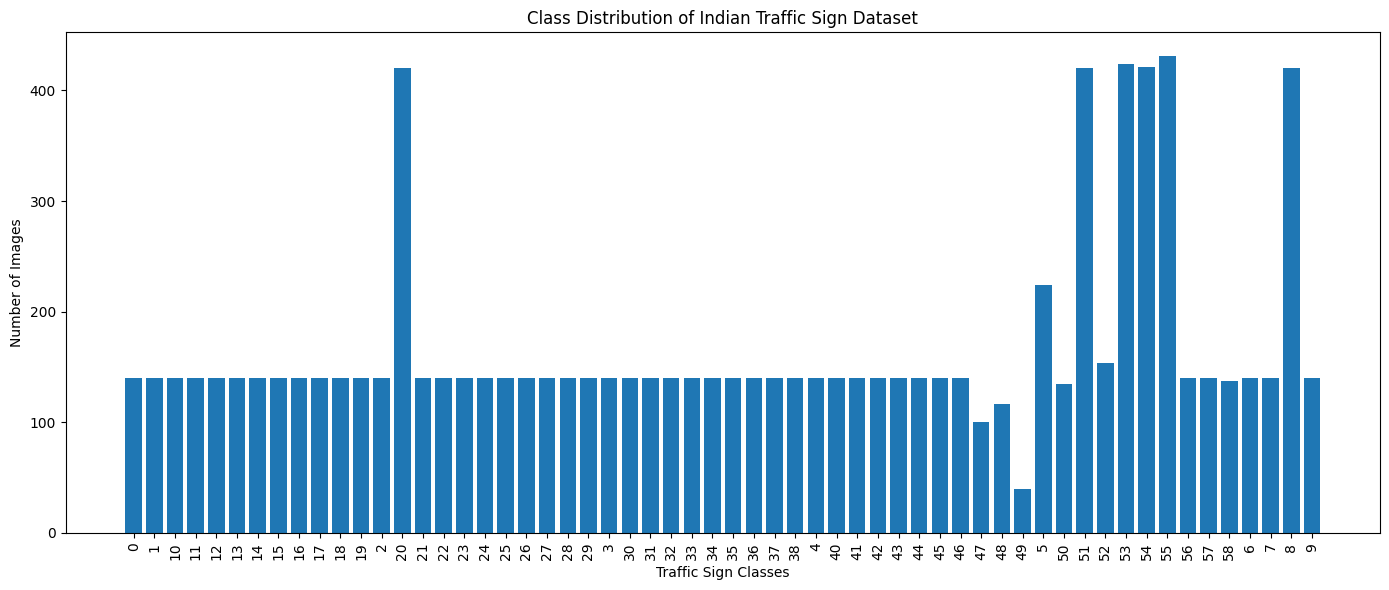

In [ ]:
import matplotlib.pyplot as plt

classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(14,6))
plt.bar(classes, counts)
plt.xticks(rotation=90)
plt.xlabel("Traffic Sign Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution of Indian Traffic Sign Dataset")
plt.tight_layout()
plt.savefig("class_distribution.png", dpi=300)
plt.show()


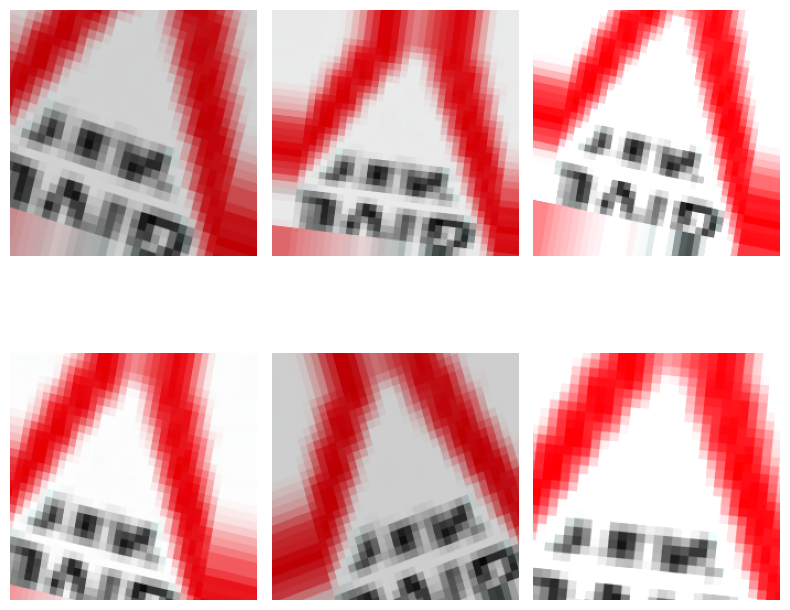

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import os

# Augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    brightness_range=[0.6, 1.4],
    shear_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Pick one sample image
sample_class = sorted(os.listdir(train_dir))[0]
sample_img_path = os.path.join(
    train_dir,
    sample_class,
    os.listdir(os.path.join(train_dir, sample_class))[0]
)

# Load and preprocess image correctly
img = load_img(sample_img_path, target_size=(224, 224))
img = img_to_array(img)
img = img.reshape((1,) + img.shape)

# Generate augmented images
aug_iter = datagen.flow(img, batch_size=1)

# Plot
plt.figure(figsize=(8,8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    augmented = next(aug_iter)[0].astype('uint8')
    plt.imshow(augmented)
    plt.axis('off')

plt.tight_layout()
plt.savefig("augmentation_examples.png", dpi=300)
plt.show()


In [2]:
!git init


hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [3]:
!git add .


In [4]:
!git commit -m "Initial commit"


Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@88390da3fd36.(none)')


In [5]:
!git config --global user.email "vnaman528@gmail.com"
!git config --global user.name "tensai77"


In [6]:
!git commit -m "Initial commit"


[master (root-commit) 9f5de10] Initial commit
 21 files changed, 51059 insertions(+)
 create mode 100644 .config/.last_opt_in_prompt.yaml
 create mode 100644 .config/.last_survey_prompt.yaml
 create mode 100644 .config/.last_update_check.json
 create mode 100644 .config/active_config
 create mode 100644 .config/config_sentinel
 create mode 100644 .config/configurations/config_default
 create mode 100644 .config/default_configs.db
 create mode 100644 .config/gce
 create mode 100644 .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
 create mode 100644 .config/logs/2026.02.06/14.30.32.592228.log
 create mode 100644 .config/logs/2026.02.06/14.31.19.332851.log
 create mode 100644 .config/logs/2026.02.06/14.31.28.771044.log
 create mode 100644 .config/logs/2026.02.06/14.31.35.535753.log
 create mode 100644 .config/logs/2026.02.06/14.31.44.938153.log
 create mode 100644 .config/logs/2026.02.06/14.31.45.734270.log
 create mode 100755 sample_data/README.md
 create mode 1007

In [8]:
!git branch -M main



In [9]:
!git remote add origin https://github.com/tensai77/PBL.git

error: remote origin already exists.


In [10]:
!git push -u origin main

fatal: could not read Username for 'https://github.com': No such device or address
